**Logistic Regression and XGBoost models for Credit Card Details Binary Classification Problem** <br>
https://www.kaggle.com/datasets/rohitudageri/credit-card-details?select=Credit_card.csv <br>

Compared accuracies of Logestic Regression and XGBoost models with ROC Curve after accounting for the unbalanced data in our models.

In [88]:
library(tidyverse)
library(xgboost)

In [89]:
#Read data and read missing values as NA
cc = read.csv("Credit_card.csv", na.strings=c("","NA"), stringsAsFactors = TRUE)
head(cc)

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>
1,5008827,M,Y,Y,0,180000,Pensioner,Higher education,Married,House / apartment,-18772,365243,1,0,0,0,NA,2
2,5009744,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NA,2
3,5009746,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,NA,-586,1,1,1,0,NA,2
4,5009749,F,Y,N,0,NA,Commercial associate,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NA,2
5,5009752,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NA,2
6,5009753,NA,Y,N,0,315000,Pensioner,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NA,2


In [90]:
#Any duplicated data?
sum(duplicated(cc))

[1] 0

In [91]:
#Create Age column from the Birthday_count column
cc$Age = abs(floor(cc$Birthday_count / 365))

In [92]:
labels = read.csv("Credit_card_label.csv")
cc$label = as.factor(labels$label)

In [93]:
head(cc)

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,Age,label
,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<dbl>,<fct>
1,5008827,M,Y,Y,0,180000,Pensioner,Higher education,Married,House / apartment,-18772,365243,1,0,0,0,NA,2,52,1
2,5009744,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NA,2,38,1
3,5009746,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,NA,-586,1,1,1,0,NA,2,NA,1
4,5009749,F,Y,N,0,NA,Commercial associate,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NA,2,38,1
5,5009752,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NA,2,38,1
6,5009753,NA,Y,N,0,315000,Pensioner,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NA,2,38,1


In [94]:
#Will drop the columns that are not very useful for our predictions
#"Ind_ID", "Mobile_phone", "EMAIL_ID", "Phone", "Work_Phone" 
#We do not need the Birthday_count column anymore
cc = cc[,-c(1,11,13:16)]

In [95]:
head(cc)

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Employed_days,Type_Occupation,Family_Members,Age,label
,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<dbl>,<fct>
1,M,Y,Y,0,180000,Pensioner,Higher education,Married,House / apartment,365243,NA,2,52,1
2,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,-586,NA,2,38,1
3,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,-586,NA,2,NA,1
4,F,Y,N,0,NA,Commercial associate,Higher education,Married,House / apartment,-586,NA,2,38,1
5,F,Y,N,0,315000,Commercial associate,Higher education,Married,House / apartment,-586,NA,2,38,1
6,NA,Y,N,0,315000,Pensioner,Higher education,Married,House / apartment,-586,NA,2,38,1


In [96]:
# Fill in NA age values with the average of age column
cc$Age[which(is.na(cc$Age))] = round(mean(cc$Age, na.rm = TRUE))

In [97]:
# Positive values mean unemployed so we change the positive employed_days to 0
cc$Employed_days[which(cc$Employed_days >0)] = 0

#Change the employed_days negative numbers to positive ones to make more sense.
cc$Employed_days = (-1) * cc$Employed_days
summary(cc$Employed_days)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   431.8  1565.0  2217.0  3174.5 14887.0 

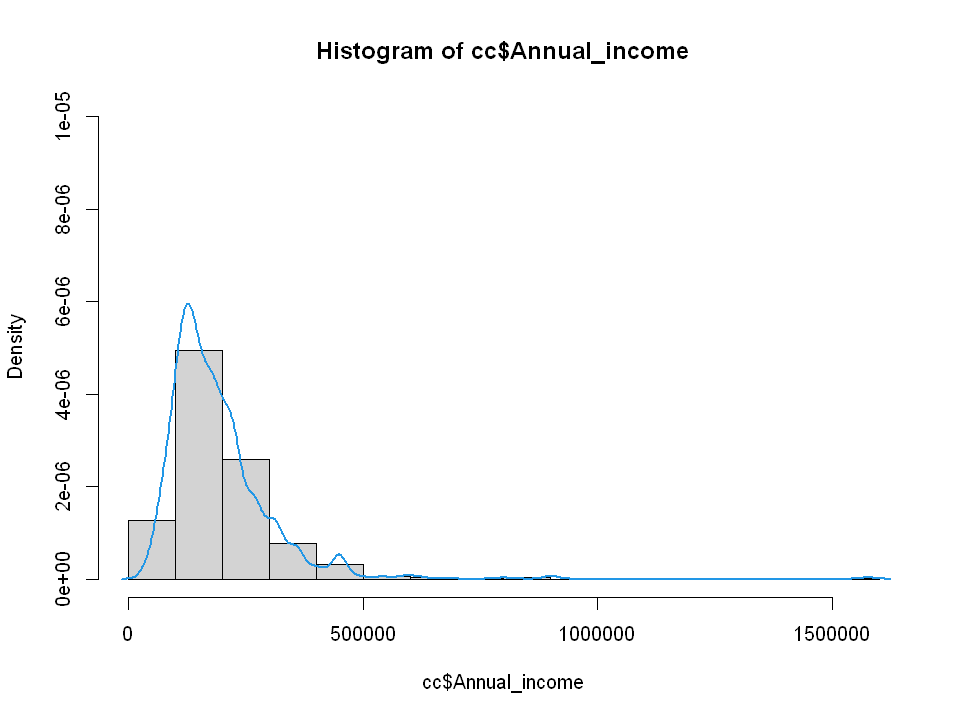

In [98]:
#Checking out the Annual_income distribution
options(repr.plot.width =8 , repr.plot.height =6)
hist(cc$Annual_income, prob = TRUE, ylim = c(0,0.00001))
lines(density(cc$Annual_income, na.rm =TRUE),col = 4, lwd = 2)

In [99]:
#Annual_income has some outliers so we will fill in the NA values with median instead of mean
cc$Annual_income[which(is.na(cc$Annual_income))] = round(median(cc$Annual_income, na.rm = TRUE))

In [100]:
#Fill in NA values of the Type_Occupation column with the most frequent value
sort(table(cc$Type_Occupation), decreasing = TRUE)[1]
cc$Type_Occupation[which(is.na(cc$Type_Occupation))] = "Laborers"

Laborers 
     268

In [101]:
#Fill in NA values of the Gender column with the most frequent value
table(cc$GENDER)
cc$GENDER[which(is.na(cc$GENDER))] = "F"


  F   M 
973 568 

In [102]:
sum(is.na(cc))

[1] 0

In [103]:
str(cc)

'data.frame':	1548 obs. of  14 variables:
 $ GENDER         : Factor w/ 2 levels "F","M": 2 1 1 1 1 1 1 1 2 2 ...
 $ Car_Owner      : Factor w/ 2 levels "N","Y": 2 2 2 2 2 2 2 1 2 2 ...
 $ Propert_Owner  : Factor w/ 2 levels "N","Y": 2 1 1 1 1 1 1 1 2 2 ...
 $ CHILDREN       : int  0 0 0 0 0 0 0 0 1 1 ...
 $ Annual_income  : num  180000 315000 315000 166500 315000 ...
 $ Type_Income    : Factor w/ 4 levels "Commercial associate",..: 2 1 1 1 1 2 1 2 1 2 ...
 $ EDUCATION      : Factor w/ 5 levels "Academic degree",..: 2 2 2 2 2 2 2 5 5 5 ...
 $ Marital_status : Factor w/ 5 levels "Civil marriage",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Housing_type   : Factor w/ 6 levels "Co-op apartment",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Employed_days  : num  0 586 586 586 586 586 586 0 678 678 ...
 $ Type_Occupation: Factor w/ 18 levels "Accountants",..: 9 9 9 9 9 9 9 9 4 4 ...
 $ Family_Members : int  2 2 2 2 2 2 2 2 3 3 ...
 $ Age            : num  52 38 44 38 38 38 38 61 50 50 ...
 $ label          : Factor w/ 

**Scale Data:** \
It only makes sense to scale the numerical columns. Which are:
CHILDREN, Annual_income, Employed_days, Family_Members, Age

In [104]:
cc[,c(4, 5, 10, 12, 13)] = scale(cc[,c(4, 5, 10, 12, 13)])
head(cc)

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Employed_days,Type_Occupation,Family_Members,Age,label
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>
1,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.65805297,1
2,F,Y,N,-0.5314733,1.10246741,Commercial associate,Higher education,Married,House / apartment,-0.6786456,Laborers,-0.1703983,-0.55899123,1
3,F,Y,N,-0.5314733,1.10246741,Commercial associate,Higher education,Married,House / apartment,-0.6786456,Laborers,-0.1703983,-0.03740086,1
4,F,Y,N,-0.5314733,-0.21813907,Commercial associate,Higher education,Married,House / apartment,-0.6786456,Laborers,-0.1703983,-0.55899123,1
5,F,Y,N,-0.5314733,1.10246741,Commercial associate,Higher education,Married,House / apartment,-0.6786456,Laborers,-0.1703983,-0.55899123,1
6,F,Y,N,-0.5314733,1.10246741,Pensioner,Higher education,Married,House / apartment,-0.6786456,Laborers,-0.1703983,-0.55899123,1


In [105]:
#Our data is unbalanced, there are much more 0 labels than 1 labels.
table(labels = cc$label)

labels
   0    1 
1373  175 

In order to take into account the unbalanced data, we need to **under-sapmle** from the rows that have label 0 and **over-sample** from the rows that have label 1.

In [106]:
#Under sampling from rows with label 0
rows_0 = which(cc$label == 0)
balance_rows_0= sort(sample(rows_0, 0.5 * nrow(cc)))
length(balance_rows_0)

[1] 774

In [107]:
#Over sampling from rows with label 1
rows_1 = which(cc$label == 1)
balance_rows_1= sort(sample(rows_1, 0.5 * nrow(cc), replace = TRUE))
length(balance_rows_1)

[1] 774

In [108]:
#put them back together to create our balanced data set
cc_balanced = cc[c(balance_rows_1, balance_rows_0),]
table(labels = cc_balanced$label)

labels
  0   1 
774 774 

In [109]:
head(cc_balanced)

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Employed_days,Type_Occupation,Family_Members,Age,label
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>
1,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.1,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.2,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.3,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.4,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.5,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1


**Split data to test and train** \
Now that we balanced our data set we can split 70% of the data into training set, by randomly selecting 70% of the number of rows of our data frame and putting the remaining into our test set.

In [110]:
set.seed(22)
train_rows= sort(sample(nrow(cc_balanced), 0.7 * nrow(cc_balanced)))
cc_train = cc_balanced[train_rows,]
cc_test = cc_balanced[-train_rows,]

**Logistic Regression**

In [111]:
table(cc_train$label)[1]/nrow(cc_train)
table(cc_test$label)[1]/nrow(cc_test)

0 
0.5041551

0 
0.4903226

We see that label 1 is evenly distributed in both train and test sets now.

In [112]:
head(cc_train)

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Employed_days,Type_Occupation,Family_Members,Age,label
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>
1,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.1,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.2,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.3,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.4,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1
1.5,M,Y,Y,-0.5314733,-0.09808393,Pensioner,Higher education,Married,House / apartment,-0.9224786,Laborers,-0.1703983,0.658053,1


In [113]:
#Implement logistic regression model
set.seed(22)
log_model = glm(label ~ ., data = cc_train, family = "binomial")
summary(log_model)


Call:
glm(formula = label ~ ., family = "binomial", data = cc_train)

Coefficients:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                               1.06401 1680.54842   0.001 0.999495
GENDERM                                   0.32842    0.16411   2.001 0.045366
Car_OwnerY                               -0.05642    0.15546  -0.363 0.716635
Propert_OwnerY                           -0.19812    0.14717  -1.346 0.178250
CHILDREN                                 -0.35782    0.29189  -1.226 0.220247
Annual_income                             0.13672    0.08020   1.705 0.088251
Type_IncomePensioner                      0.18109    0.27944   0.648 0.516964
Type_IncomeState servant                 -1.43585    0.33735  -4.256 2.08e-05
Type_IncomeWorking                       -0.38543    0.17831  -2.162 0.030649
EDUCATIONHigher education                14.02218 1455.39760   0.010 0.992313
EDUCATIONIncomplete higher               12.88257 1455.39

Let's see which features had smaller p-values in our full model. This means the features that our model estimated to have more effect on predicting our outcomes.

In [114]:
alpha = 0.05
summary(log_model)$coef[which(summary(log_model)$coef[,4] < alpha),]

,Estimate,Std. Error,z value,Pr(>|z|)
GENDERM,0.3284196,0.16410782,2.001243,4.536622e-02
Type_IncomeState servant,-1.4358486,0.33734600,-4.256308,2.078299e-05
Type_IncomeWorking,-0.3854322,0.17830887,-2.161598,3.064914e-02
Marital_statusSeparated,2.2807854,0.57929881,3.937149,8.245558e-05
Marital_statusSingle / not married,1.6679064,0.50289408,3.316616,9.111485e-04
Marital_statusWidow,1.2677790,0.60802209,2.085087,3.706139e-02
Employed_days,-0.2228051,0.09078447,-2.454221,1.411902e-02


In our logistic regression model, above features are playing a role in predicting the application rejection status.

**Logistic Regression Test Accuracy**

Now we want to see how accurate our model was:

In [115]:
#what our model predicted
predict_labels_prob = predict(log_model, newdata = cc_test, type = "response")
predict_labels = ifelse(predict_labels_prob <0.5, 0, 1)

In [116]:
t = table(predictions = predict_labels, actual_labels = cc_test$label)
confusionMatrix(t)

Confusion Matrix and Statistics

           actual_labels
predictions   0   1
          0 144  70
          1  84 167
                                         
               Accuracy : 0.6688         
                 95% CI : (0.624, 0.7115)
    No Information Rate : 0.5097         
    P-Value [Acc > NIR] : 2.782e-12      
                                         
                  Kappa : 0.3366         
                                         
 Mcnemar's Test P-Value : 0.2948         
                                         
            Sensitivity : 0.6316         
            Specificity : 0.7046         
         Pos Pred Value : 0.6729         
         Neg Pred Value : 0.6653         
             Prevalence : 0.4903         
         Detection Rate : 0.3097         
   Detection Prevalence : 0.4602         
      Balanced Accuracy : 0.6681         
                                         
       'Positive' Class : 0              
                                         

The **logistic regression model accuracy score is 0.66** which means by setting the **threshold as 0.5**, our model would be able to predict 66% of our data correctly. This is a moderate accuracy score.

We can also check out the **ROC curve** of our model too.

In [117]:
roc_obj = roc(cc_test$label, predict_labels)

#get the AUC
auc_value = auc(roc_obj)
print(auc_value)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6681


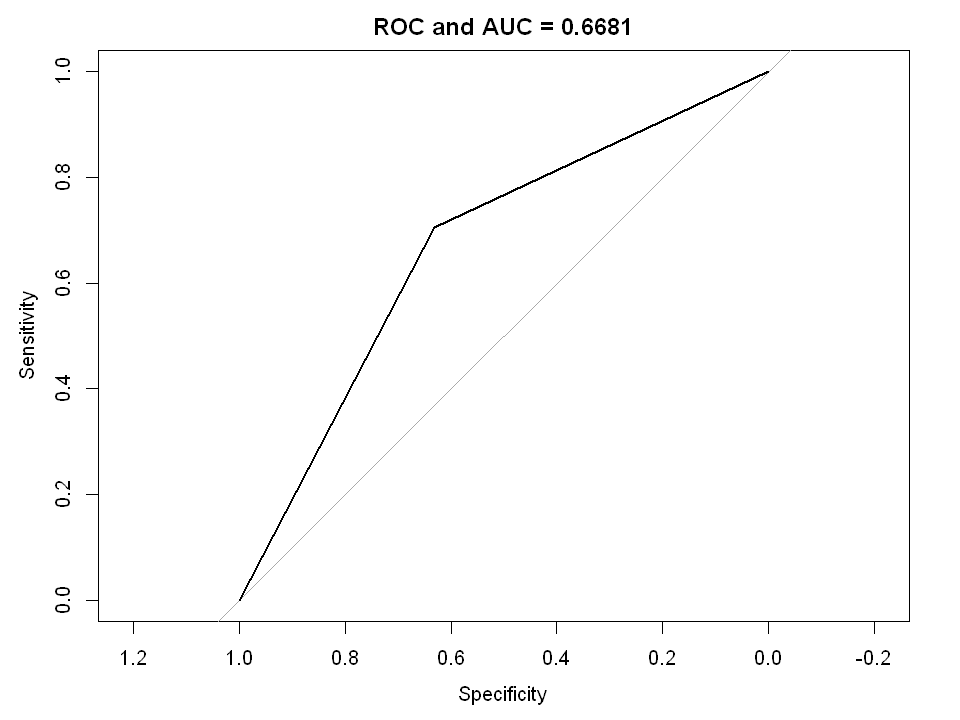

In [118]:
options(repr.plot.width =8 , repr.plot.height =6)

plot(roc_obj, main = paste("ROC and AUC =", round(auc_value, 4)))

The Roc curve is not so much great, for incresing the sensitivity of our model, it sacrifices the specificity of it a lot. \
This means for being able to predict rejected applications correctly(label = 1), it will also predict some approved (label = 0) ones as rejected (label = 1). 

**XGBoost on unbalanced classes**

In [119]:
#Dummify our features to be able to use it in xgboost model
#Use fullRank option to have one less variable than the number of categories to avoid collinearity
dmy = dummyVars(" ~ .", data=cc[,-14], fullRank=T)
cc_dmy <- data.frame(predict(dmy, newdata = cc[,-14]))
head(cc_dmy)

,GENDER.M,Car_Owner.Y,Propert_Owner.Y,CHILDREN,Annual_income,Type_Income.Pensioner,Type_Income.State.servant,Type_Income.Working,EDUCATION.Higher.education,EDUCATION.Incomplete.higher,⋯,Type_Occupation.Managers,Type_Occupation.Medicine.staff,Type_Occupation.Private.service.staff,Type_Occupation.Realty.agents,Type_Occupation.Sales.staff,Type_Occupation.Secretaries,Type_Occupation.Security.staff,Type_Occupation.Waiters.barmen.staff,Family_Members,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,-0.5314733,-0.09808393,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,-0.1703983,0.65805297
2,0,1,0,-0.5314733,1.10246741,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,-0.1703983,-0.55899123
3,0,1,0,-0.5314733,1.10246741,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,-0.1703983,-0.03740086
4,0,1,0,-0.5314733,-0.21813907,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,-0.1703983,-0.55899123
5,0,1,0,-0.5314733,1.10246741,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,-0.1703983,-0.55899123
6,0,1,0,-0.5314733,1.10246741,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,-0.1703983,-0.55899123


In [125]:
#Split our data into train and test again
set.seed(50)
train_indices_dmy= sort(sample(nrow(cc_dmy), 0.7 * nrow(cc_dmy)))
cc_train_dmy = cc_dmy[train_indices_dmy,]
cc_test_dmy = cc_dmy[-train_indices_dmy,]

In [126]:
#positive and negative cases and their distribution in the train set
train_labels = cc$label[train_indices_dmy]
positive_cases = sum(train_labels == 1)
negative_cases = sum(train_labels == 0)
table(labels = train_labels)

labels
  0   1 
963 120 

In [127]:
#accounting the unbalanced data
scale_pos_weight_value = negative_cases / positive_cases
scale_pos_weight_value

[1] 8.025

**Implement XGboost model**

In [128]:
#XGboost matrix
dtrain = xgb.DMatrix(data = as.matrix(cc_train_dmy), 
                     label = as.numeric(cc$label[train_indices_dmy]) - 1)

dtest = xgb.DMatrix(data = as.matrix(cc_test_dmy), 
                    label = as.numeric(cc$label[-train_indices_dmy]) - 1)

#Since our label column only has 2 levels, we will set our XGboost loss function to a binary classification
# Train the model
xgb_model = xgb.train(data = dtrain, 
                      nrounds = 100,
                     objective = "binary:logistic",
                     scale_pos_weight = scale_pos_weight_value)

In [129]:
# Predictions
predicted_labels = predict(xgb_model, newdata = dtest, type = "response")
predicted_labels = ifelse(predicted_labels > 0.5, 1, 0)

**XGBoost Test Accuracy**

In [130]:
test_labels = as.numeric(cc$label[-train_indices_dmy]) - 1
accuracy_xgb = sum(predicted_labels == test_labels) / length(test_labels)
print(paste("XGBoost Accuracy:", accuracy_xgb))

[1] "XGBoost Accuracy: 0.903225806451613"


In [131]:
t = table(predictions = predicted_labels, actual_labels = test_labels)
confusionMatrix(t)

Confusion Matrix and Statistics

           actual_labels
predictions   0   1
          0 387  22
          1  23  33
                                          
               Accuracy : 0.9032          
                 95% CI : (0.8727, 0.9285)
    No Information Rate : 0.8817          
    P-Value [Acc > NIR] : 0.08349         
                                          
                  Kappa : 0.5397          
                                          
 Mcnemar's Test P-Value : 1.00000         
                                          
            Sensitivity : 0.9439          
            Specificity : 0.6000          
         Pos Pred Value : 0.9462          
         Neg Pred Value : 0.5893          
             Prevalence : 0.8817          
         Detection Rate : 0.8323          
   Detection Prevalence : 0.8796          
      Balanced Accuracy : 0.7720          
                                          
       'Positive' Class : 0               
                      

**ROC curve**

In [132]:
roc_obj_xgb = roc(test_labels, predicted_labels)

#get the AUC
auc_value_xgb = auc(roc_obj_xgb)
print(auc_value_xgb)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.772


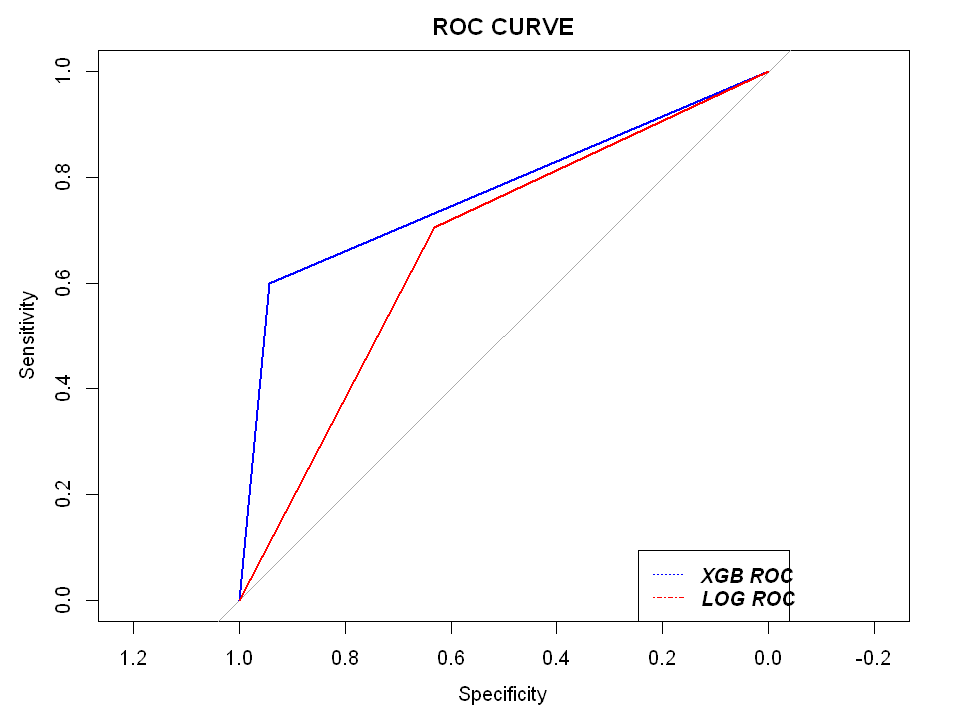

In [133]:
options(repr.plot.width =8 , repr.plot.height =6)

plot(roc_obj_xgb, col = "blue", main = "ROC CURVE")
lines(roc_obj, col = "red")
legend(x = "bottomright", lty = c(3,4), text.font = 4,  
       col= c("blue","red"),text.col = "black",  
       legend=c("XGB ROC", "LOG ROC")) 